# Reproduce Figure 3 of Group Invariant Scattering (Mallat, 2012)

In [292]:
%matplotlib inline

import pylab as plt

import numpy as np

from scipy.fftpack import fft
from scipy.signal import unit_impulse

from blusky.transforms.apply_father_wavelet_1d import ApplyFatherWavlet1D
from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.cascade_1d import Cascade1D
from blusky.transforms.default_decimation import (NoDecimation, 
                                                  DefaultDecimation)
from blusky.transforms.i_decimation_method import IDecimationMethod
from blusky.wavelets.i_wavelet_1d import IWavelet1D
from blusky.utils.pad_1d import pad_to_log2, Pad1D
from blusky.wavelets.wavelet_factories_1d import (vanilla_gabor_1d, 
                                                  vanilla_morlet_1d,
                                                  calibrate_wavelets_1d)
from keras.layers import Input
from keras import Model


In [230]:
N = 8 * 1024 # signal size, power of two

# example signals
# Indicator function of an interval
R = 20 #half width of window
start = np.int(N/2-R)
end = np.int(N/2 + R)

f1 = np.zeros(N)
f1[start:end] = 1
f1 = f1 /np.sum(np.abs(f1));
A1 = np.abs(fft(f1))

# First Gabor function
x = np.arange(N)+1
f2 = np.exp((-(x-N/2)**2)/2048)*np.cos(np.pi*x*0.9/3)
f2 = f2 / np.sum(np.abs(f2))
A2 = np.abs(fft(f2))

# Dilated Gabor Function
f3 = np.exp((-(1.1)**2*(x-N/2)**2)/2048)*np.cos(np.pi*x*1.1*0.9/3)
f3 = f3 / np.sum(np.abs(f3))
A3 = np.abs(fft(f3))

# Sum of a Gabor function and a dilated Gabor function
f4 = np.exp((-(x-N/2)**2)/8192)*np.cos(np.pi*x*0.95/3) + np.exp((-(x-N/2)**2)/8192)*np.cos(np.pi*x*1/3*1.05)
f4 = f4 /np.sum(np.abs(f4));
A4 = np.abs(fft(f4))



## 1D Scattering transforms

Now apply the scattering transform to the signals f1 to f4 defined above.

In [271]:
Jmax = np.int(np.log2(N)) # maximum number of scales
order = 3
sample_rate = 1
# arbitrary rate of oversampling

conv_padding = "valid"
J = Jmax - 2

wavelets = [vanilla_morlet_1d(sample_rate, J, j=i) 
                    for i in range(0,J)]
calibrate_wavelets_1d(wavelets)

father_wavelet = vanilla_gabor_1d(sample_rate, J)

deci = NoDecimation() #DefaultDecimation(oversampling=oversampling)
inp = Input(shape=(N,1))

# pad
pad_1d = Pad1D(wavelets, decimation=deci)
padded = pad_1d.pad(inp)

cascade_tree = CascadeTree(padded, order=order)

cascade = Cascade1D(decimation=deci)
convs = cascade.transform(cascade_tree, wavelets=wavelets)

# Create layers to remove padding
cascade_tree = CascadeTree(padded, order=order)
cascade_tree.generate(wavelets, pad_1d.unpad)
unpad = cascade_tree.get_convolutions()

# Remove the padding
unpadded_convs = [i[1](i[0]) for i in zip(convs, unpad)]

model = Model(inputs=inp, outputs=unpadded_convs)

data = np.zeros((1,N,1))
data[0,:,0] = f1[:N]

result = model.predict(data)
scat1= result[0][0,:,0]

/home/brendon/Projects/blusky/blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


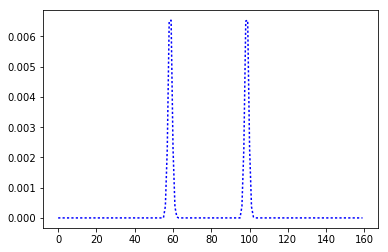

In [270]:
plt.plot(result[0][0,start_plot:end_plot,0],":b")
#plt.plot(f1)

In [313]:
def basic_mst(func, order=2, sample_rate=1, oversampling=1, dirac=False):

    N = func.shape[0]
    
    Jmax = np.int(np.log2(N))
    #order = 2
    #sample_rate = 1
    #oversampling = 1
    conv_padding = "valid"
    J = Jmax - 2

    wavelets = [vanilla_morlet_1d(sample_rate, J, j=i) 
                        for i in range(0,J)]
    calibrate_wavelets_1d(wavelets)

    father_wavelet = vanilla_gabor_1d(sample_rate, J)

    deci = DefaultDecimation(oversampling=oversampling)
    inp = Input(shape=(N,1))

    # pad
    pad_1d = Pad1D(wavelets, decimation=deci, conv_padding=conv_padding)
    padded = pad_1d.pad(inp)

    #
    cascade_tree = CascadeTree(padded, order=order)

    cascade = Cascade1D(decimation=deci, _padding=conv_padding)
    convs = cascade.transform(cascade_tree, wavelets=wavelets)

    # Create layers to remove padding
    cascade_tree = CascadeTree(padded, order=order)
    cascade_tree.generate(wavelets, pad_1d.unpad)
    unpad = cascade_tree.get_convolutions()

    # Remove the padding
    unpadded_convs = [i[1](i[0]) for i in zip(convs, unpad)]

    appl = ApplyFatherWavlet1D(wavelet=father_wavelet, 
                               J=J, 
                               img_size=(N,), 
                               sample_rate=sample_rate)
    sca_transf = appl.convolve(unpadded_convs)

    model = Model(inputs=inp, outputs=sca_transf)

    data = np.zeros((1,N,1))
    data[0,:,0] = func[:N]
    
    
    
    result = model.predict(data)
    scat_coeffs = np.squeeze(result)
    
    if dirac:
        dirac = unit_impulse(N,idx='mid', dtype=np.int8)
        _data = np.zeros((1,N,1))
        _data[0,:,0] = dirac[:N]
        _result = model.predict(_data)
        scat_coeffs = scat_coeffs / np.squeeze(_result)
    
    return np.squeeze(scat_coeffs)

In [314]:
scat1 = basic_mst(f1, order=3, dirac=True)

/home/brendon/Projects/blusky/blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


In [315]:
scat2 = basic_mst(f2, order=3, dirac=True)

/home/brendon/Projects/blusky/blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


In [316]:
scat3 = basic_mst(f3, order=3, dirac=True)

/home/brendon/Projects/blusky/blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


In [317]:
scat4 = basic_mst(f4, order=3, dirac=True)

/home/brendon/Projects/blusky/blusky/blusky/wavelets/wavelet_factories_1d.py:46: RuntimeWarning: invalid value encountered in double_scalars
  step = np.pi * 2**(-J/Q) * (1-1/4*sigma0/_sigma_phi*2**(1./Q))/P


(0, 1)

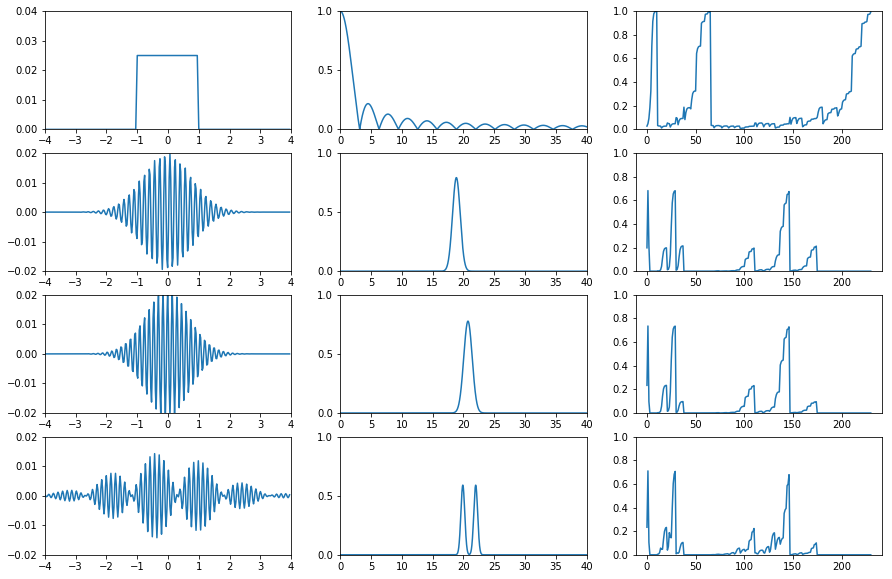

In [318]:
# start_plot = np.int(N/2 - 4*R)
end_plot = np.int(N/2 + 4*R)

#domain for f1
num = f1[start_plot:end_plot].shape[0]
w = np.arange(1,num+1)
w = (w-1) * 8/num -4

# domain for f2 to f4
num = 16*R+1
w2 = np.arange(1,num)
w2 = (w2-1) * 8/num -4

# domain for fourier series
P = np.int(N/2)
z = np.arange(0,P)
z = 10*z*2*np.pi / P

fig, ax = plt.subplots(4,3, figsize=(15,10))

ax[0,0].plot(w,f1[start_plot:end_plot])
ax[0,0].set_xlim((-4,4))
ax[0,0].set_ylim((0,0.04))
ax[0,1].plot(z,A1[0:np.int(N/2)])
ax[0,1].set_xlim((0,40))
ax[0,1].set_ylim((0,1))
ax[0,1].set_yticks([0, 0.5, 1])
ax[0,2].plot(scat1)
ax[0,2].set_ylim((0,1))

ax[1,0].plot(w2,f2[np.int(N/2 - 8*R):np.int(N/2 + 8*R)])
ax[1,0].set_xlim((-4,4))
ax[1,0].set_ylim((-0.02,.02))
ax[1,1].plot(z,A2[0:np.int(N/2)])
ax[1,1].set_xlim((0,40))
ax[1,1].set_ylim((0,1))
ax[1,1].set_yticks([0, 0.5, 1])
ax[1,2].plot(scat2)
ax[1,2].set_ylim((0,1))

ax[2,0].plot(w2,f3[np.int(N/2 - 8*R):np.int(N/2 + 8*R)])
ax[2,0].set_xlim((-4,4))
ax[2,0].set_ylim((-0.02,0.02))
ax[2,1].plot(z,A3[0:np.int(N/2)])
ax[2,1].set_xlim((0,40))
ax[2,1].set_ylim((0,1))
ax[2,1].set_yticks([0, 0.5, 1])
ax[2,2].plot(scat3)
ax[2,2].set_ylim((0,1))

ax[3,0].plot(w2,f4[np.int(N/2 - 8*R):np.int(N/2 + 8*R)])
ax[3,0].set_xlim((-4,4))
ax[3,0].set_ylim((-0.02,0.02))
ax[3,1].plot(z,A4[0:np.int(N/2)])
ax[3,1].set_xlim((0,40))
ax[3,1].set_ylim((0,1))
ax[3,1].set_yticks([0, 0.5, 1])
ax[3,2].plot(scat4)
ax[3,2].set_ylim((0,1))

## This is Figure 3 in the GIS paper:

<img src="GIS_figure3.png">

This is the MATLAB code to generate Figure 3 (above) in the GIS paper.

```python
% Reproduction of the Figure 3.2 of in the paper:
% “Group Invariant Scattering”, S. Mallat,
% Comm. in Pure and Applied Mathematics, Dec. 2012, Wiley
%
% Fourier transforms and scattering transforms of 4 different signals.

N = 8*1024; %signal size, power of two
Jmax = log2(N); %Maximum number of scales
%Choice of the wavelet
fparam.filter_type = {‘spline_1d’};
fparam.spline_order=3;
% Scale 2^J selected to display the scattering representation
fparam.J = Jmax-1;
fparam.Q = 1;
options.M = fparam.J;
Wop = wavelet_factory_1d(N, fparam, options);
% Examples of signals
%Indicator function of an interval
f1 = zeros(1,N);
R = 20;
  f1(N/2-R:N/2+R) = 1;
f1 = f1 ./sum(abs(f1));
f1=f1';
% Scattering transform
% tic
 Scat1 = diracNormScatt(f1,Wop);
% toc
P = length(Scat1);
y = zeros(1,P);
y(1:P) = (1:P);
y = 10 * y* 2 * pi/(P);
P = 8*R+1;
w = zeros(1,R);
w(1:P) = (1:P);
w = (w-1)*8/(P)-4;
figure(1);
hold off;
subplot(4,3,1), plot(w,f1(N/2-4*R:N/2+4*R));
%subplot(4,3,3), plotnormScatt(y,Scat1, Sdirac1, order1); %Scattered representation at the scale 2^J
subplot(4,3,3), plot(y,Scat1); %Scattered representation at the scale 2^J
% Modulus of the Fourier transform
A1 = abs(fft(f1));
P = N/2;
z = zeros(1,P);
z(1:P) = (1:P);
z =10 *  z* 2 * pi/(P);
subplot(4,3,2), plot(z,A1(1:N/2));
%plot(Scat1(:,J-1),‘g’);
hold off;
P = 16*R+1;
w = zeros(1,P);
w(1:P) = (1:P);
%w = w* 50(P);
w = (w-1)*8/(P)-4;
%First Gabor function
f1 = zeros(1,N);
R = 20;

  f1(1:N) = exp(-((1:N)-N/2).^2/(2 * (1024/32).^2)) .* cos(pi * (1:N)*0.90/3);
    
    
f1 = f1 ./sum(abs(f1));
f1=f1';
Scat1 = diracNormScatt(f1,Wop);
P = length(Scat1);
y = zeros(1,P);
y(1:P) = (1:P);
y = 10 * y* 2 * pi/(P);
hold off;
subplot(4,3,4), plot(w,f1(N/2-8*R:N/2+8*R));
subplot(4,3,6), plot(y,Scat1); %Scattered representation at the scale 2^J
A1 = abs(fft(f1));
P = N/2;
z = zeros(1,P);
z(1:P) = (1:P);
z = 10 * z* 2 * pi/(P);
subplot(4,3,5), plot(z,A1(1:N/2));
%plot(Scat1(:,J-1),‘g’);
hold off;
%Dilated Gabor Function
f2 = zeros(1,N);
R = 20;
  f2(1:N) = exp(-(1.1).^2*((1:N)-N/2).^2/(2 * (1024/32).^2)) .* cos(pi * (1:N)*1.1*0.9/3);
f2 = f2 ./sum(abs(f2));
f2=f2';
subplot(4,3,7), plot(w,f2(N/2-8*R:N/2+8*R));
Scat2 = diracNormScatt(f2,Wop);
%Scat2 = NormScatter(f2,wavelet_name,Jmax,‘White’);
%Scat = Scatter(f2,wavelet_name,Jmax,‘White’);
%figure(2);
hold off;
subplot(4,3,9),plot(y,Scat2); %Scattered representation at the scale 2^J
A2 = abs(fft(f2));
P = N/2;
z(1:P) = (1:P);
z = 10 * z* 2 * pi/(P);
subplot(4,3,8), plot(z,A2(1:N/2));
hold on;
%plot(Scat2(:,J-1),‘g’);
hold off;
%sum of a Gabor function and of a dilated Gabor function
f4 = zeros(1,N);
R = 20;
  f4(1:N) = exp(-((1:N)-N/2).^2/(2 * (1024/16).^2)) .* cos(pi * (1:N)*0.95/3) + exp(-((1:N)-N/2).^2/(2 * (1024/16).^2)) .* cos(pi * (1:N)*1/3*1.05) ;
f4 = f4 ./sum(abs(f4));
f4=f4';
Scat4 = diracNormScatt(f4,Wop);
P = length(Scat4);
y = zeros(1,P);
y(1:P) = (1:P);
y = 10 * y* 2 * pi/(P);
hold off;
subplot(4,3,10), plot(w,f4(N/2-8*R:N/2+8*R));
subplot(4,3,12), plot(y,Scat4); %Scattered representation at the scale 2^J
A4 = abs(fft(f4));
P = N/2;
z = zeros(1,P);
z(1:P) = (1:P);
z = 10 * z* 2 * pi/(P);
subplot(4,3,11), plot(z,A4(1:N/2));
%plot(Scat4(:,J-1),‘g’);
hold off;
fprintf(‘Left graphs: each row gives an example of function fi(x). \n Middle graphs: modulus of the Fourier transform of each fi \n as a function of the freRuency omega.\n Right graphs: normalized scattering transforms Sfi(R(omega))\n as a function of the freRuency omega.\n’);
```